# Code metrics analysis of [pandas](https://pandas.pydata.org/) code base

This notebooks demonstrates how to use __[codemetrics](https://github.com/elmotec/codemetrics)__ to gain insight on a code base like the one at https://github.com/pandas-dev/pandas.

In [1]:
import os
import pathlib as pl
import datetime as dt
import textwrap
import json
import pathlib as pth
import logging
import sys

import joblib
import pandas as pd
import numpy as np
import altair as alt
from altair.vega.v5 import Vega
from tqdm import tqdm

import codemetrics as cm
import codemetrics.vega

%matplotlib inline

print("pandas version:", pd.__version__)
print("altair version:", alt.__version__)

pandas version: 1.3.0
altair version: 4.1.0


In [2]:
%load_ext autoreload
%autoreload

In [3]:
log = cm.log
logging.basicConfig(format="%(relativeCreated)6d %(level)s %(message)s")
log.setLevel(logging.WARNING) 
log.info("logging enabled")

## Setup

Sets up a few useful things:

- define a few useful variables like `analysis_start_date` or the `project` under analysis.
- joblib.Memory to cache some outputs and clearing out the cache when we execute this cell.


In [4]:
# Useful variables
analysis_end_date = dt.datetime.now(tz=dt.timezone.utc)
analysis_start_date = analysis_end_date - dt.timedelta(365)

# Change current directory to the project under being analyzed.
project = cm.GitProject(pl.Path().absolute() / '..' / '..'/  'pandas')

# Sets up caching and wipes out cache if any.
disk = joblib.Memory(location=os.getenv('TEMP'), verbose=0)
get_cloc = disk.cache(cm.get_cloc)
get_cloc.clear()

## Lines of code (loc)

Leverage cloc to count the lines of code and infer some basic information about the languages used in this project.

In [5]:
cloc_program = 'cloc.exe'
loc = cm.get_cloc(project, cloc_program=cloc_program).query("language != 'SUM'")

In [6]:
loc.head(3)

language                                             path  blank  comment  \
0      SVG  doc/source/_static/schemas/04_plot_overview.svg      1        1   
1     HTML          pandas/tests/io/data/html/banklist.html     33       21   
2   Python                           pandas/core/generic.py   1736     6050   

   code  
0  6441  
1  4832  
2  3863

In [7]:
loc_sum = loc.groupby('language').sum().reset_index().melt(id_vars=['language']).rename(columns={'variable': 'type', 'value': 'lines'})
alt.Chart(loc_sum).mark_bar().encode(
    x=alt.X('lines:Q'),
    y=alt.Y('language:N', sort=alt.EncodingSortField(field='lines', op='sum', order='descending')),
    color=alt.Color('type:N', scale=alt.Scale(scheme='accent')), 
    tooltip=['lines:Q', 'type:O'],
).properties(title='Lines of code')

alt.Chart(...)

Compute significant languages for this code base to lighten up the graphs

In [8]:
significant_languages = loc.groupby('language').sum().code.nlargest(7).index.tolist()
print(", ".join(significant_languages))
loc_sl = loc.query("language in @significant_languages")

Python, reStructuredText, Cython, SVG, HTML, C, C/C++ Header


## Retrieve git log data

Now that we know what the code base looks like today, we turn our attention to history and build a data frame of the git log history for the past year. 

We then calculate the age of each file and generate a graph of recent changes as well as a circle visualization of the code base. 

In [9]:
log = cm.get_log(project, after=analysis_start_date)
log['issue'] = log['message'].str.extract(r'\(#(\d+)\)')
log = pd.merge(log, loc[['path']], left_on='path', right_on='path')

In [10]:
log.head(2)

revision         author                      date  \
0  c1aea793e0  Simon Hawkins 2021-07-24 11:19:05+00:00   
1  baf9e4bd25     neelmraman 2021-07-24 03:29:22+00:00   

                             path  \
0  doc/source/whatsnew/v1.3.1.rst   
1  doc/source/whatsnew/v1.3.1.rst   

                                             message kind action  textmods  \
0                   DOC: 1.3.1 release date (#42686)    f    NaN      True   
1  BUG: Fix bug in SeriesGroupBy.value_counts whe...    f    NaN      True   

   propmods copyfromrev copyfrompath  added  removed  issue  
0     False        <NA>         <NA>    1.0     10.0  42686  
1     False        <NA>         <NA>    1.0      1.0  42618

A first analysis that can be done is to see how often the often the code changes by visualizing the number of changes each week and the frequency of the changes.

In [11]:
ages = (log[['date', 'path']]
        .merge(loc_sl)
       )
df = (ages
      .sample(5000, random_state=42)  # altair supports a maximum of 5000 data points.
      .assign(age=lambda x: (analysis_end_date - x['date']).dt.total_seconds() / 86400)  # Altair does not handle TimeDelta64.
      .assign(week=lambda x: x.date.dt.to_period(freq='W').dt.end_time)  # Compute the end of the week for that change.
     )

c:\users\jlecomte\documents\github\codemetrics\venv\lib\site-packages\pandas\core\arrays\datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [12]:
width = 1000
chart = alt.Chart(df).encode(color='language')
top = (chart.mark_bar(size=15)
       .encode(x=alt.X('week:T', sort='ascending', title='week of'),
               y=alt.Y('count(path):Q', title='Count of files changed'),
               color=alt.Color('language', scale=alt.Scale(scheme='tableau10')),
               tooltip=['count(path)', 'language']
              )
       .properties(width=width, title='Number of changes each week')
      )
bottom = (chart.mark_tick(thickness=2,
                          opacity=.1)
          .encode(x=alt.X('date:T'), tooltip='path')
          .properties(width=width, title='Frequency of changes')
         )
alt.vconcat(top, bottom)

alt.VConcatChart(...)

Another perspective is to see how old is each file to get a sense of what has not been touched for a while.  The stronger the blue tint is, the older the file is. The size of the circle is proportional to the nuber of line in the file.

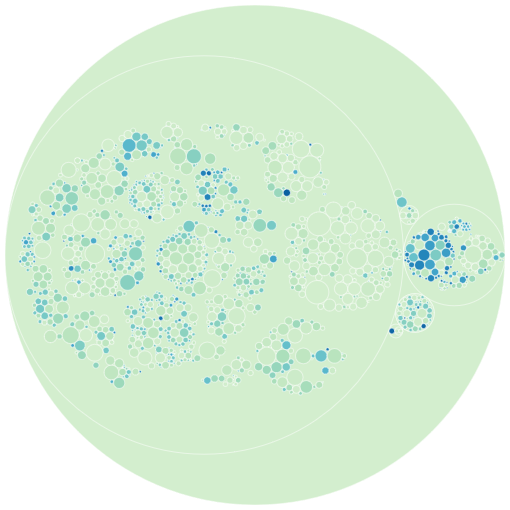

In [13]:
ages = (cm.get_ages(log)
        .merge(loc_sl)
       )
desc = cm.vega.vis_ages(ages, height=500, width=500)
Vega(desc)


## Complexity

On to complexity calculation. Here we calculate the complexity of the current code base, file by file,
function by function so it could take a little long. We run it on .py files only and we leverage tqdm to
show a progress bar.

In [14]:
# Get Python file with the most recent revision
python_df = (log[['path', 'date']]
             .groupby('path', as_index=False)
             .max()
             .query("path.str.endswith('.py')")
             .merge(log[['path', 'date', 'revision']])
             .assign(path=lambda x: x["path"].astype("string"))
            )
# Progress bar for pandas
tqdm.pandas(desc="calculating")
# Calculates complexity on python files.
complexity = (python_df[['revision', 'path']]
              .groupby(['revision', 'path'])
              .progress_apply(cm.get_complexity, project=project)
             )


calculating: 100%|█████████████████████████████████████████████████████████████████| 1165/1165 [00:44<00:00, 26.17it/s]


In [15]:
# Calculates 80% percentile of complexity for each file
path_complexity = (complexity
                   .reset_index()[['path', 'cyclomatic_complexity', 'token_count']]
                   .groupby('path').quantile(0.8)
                   .sort_values(by='cyclomatic_complexity', ascending=False)
                   .reset_index()
                   .rename(columns={'cyclomatic_complexity': 'complexity'})
                  )
# Merge to lines of code. 
loc_cc = pd.merge(loc, path_complexity)

# Hot spots

Hot spots are files that exhibit high complexity __and__ changed a lot recently. This is typically where you will find bugs.

The graph below will show files harboring complexity as large circle while an increased number of change will make the color trend from yellow to more red shades.

In [16]:
hspots = cm.get_hot_spots(log.head(1), loc_cc.head(1))

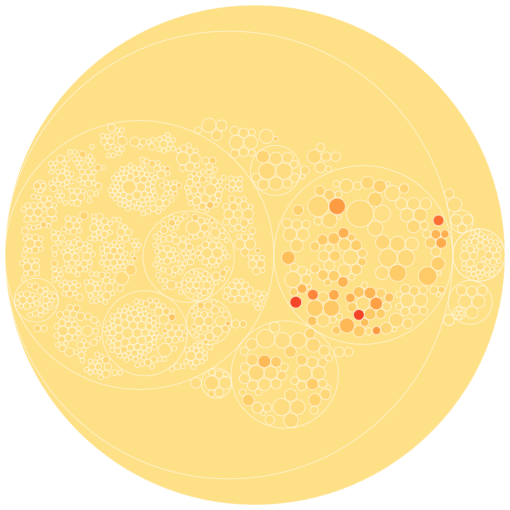

In [17]:
hspots = cm.get_hot_spots(log, loc_cc.assign(path=lambda x: x['path'].astype('string'))) 
hspots.query("language == 'Python'").sort_values(by=['changes', 'complexity'], ascending=False).head()
desc = cm.vega.vis_hot_spots(hspots, width=500, height=500, size_column='complexity')
Vega(desc)

## Co-changes or inter-file coupling

Co-changes builds on the idea that files or functions that change together imply a hidden dependency and may need refactoring.

We calculate how often each file change in relation to the other and display high level of coupling. Again, we focus on the files that have changed a lot recently.

In [18]:
co_changes = cm.get_co_changes(log, by='path', on='issue').\
    query("(coupling > .6) & (changes > 20)").\
    sort_values(by=['changes', 'cochanges'], ascending=False)
co_changes

path  \
135244                 pandas/core/indexes/multi.py   
137809                 pandas/core/indexes/range.py   
136110               pandas/core/indexes/numeric.py   
172704                    pandas/core/window/ewm.py   
93571                  pandas/core/arrays/numpy_.py   
480257        pandas/tests/io/excel/test_readers.py   
184452                 pandas/io/excel/_openpyxl.py   
85661                 pandas/core/arrays/boolean.py   
482766  pandas/tests/io/formats/style/test_style.py   
89213                pandas/core/arrays/floating.py   
173551              pandas/core/window/expanding.py   
196706            pandas/io/formats/style_render.py   

                               dependency  changes  cochanges  coupling  
135244        pandas/core/indexes/base.py      148         91  0.614865  
137809        pandas/core/indexes/base.py       73         46  0.630137  
136110        pandas/core/indexes/base.py       52         34  0.653846  
172704      pandas/core/window/rolling.py       39         26  0.666667  
93571   pandas/core/arrays/categorical.py       38         24  0.631579  
480257           pandas/io/excel/_base.py       31         19  0.612903  
184452           pandas/io/excel/_base.py       28         18  0.642857  
85661       pandas/core/arrays/integer.py       26         16  0.615385  
482766         pandas/io/formats/style.py       24         17  0.708333  
89213       pandas/core/arrays/integer.py       22         17  0.772727  
173551      pandas/core/window/rolling.py       21         19  0.904762  
196706         pandas/io/formats/style.py       21         15  0.714286

## File level analysis

It can also be useful to dive into the complexity history of one particular file or function. Let's consider the following file and calculate historical complexity of each function in the file. 

In [19]:
path = 'pandas/core/frame.py'
func_df = log[log['path'] == path][['date', 'revision', 'path']]
func_df.head()

date    revision                  path
1164 2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py
1165 2021-07-20 12:19:02+00:00  37ea2cd5e9  pandas/core/frame.py
1166 2021-07-15 23:54:03+00:00  829d16ee99  pandas/core/frame.py
1167 2021-07-12 13:19:10+00:00  a2f405354c  pandas/core/frame.py
1168 2021-07-11 09:17:04+00:00  844b388e34  pandas/core/frame.py

In [20]:
func_cplx_df = func_df.groupby(['revision', 'path']).progress_apply(cm.get_complexity, project=project)

calculating: 100%|███████████████████████████████████████████████████████████████████| 284/284 [00:31<00:00,  9.16it/s]


In [21]:
func_cpx_df = pd.merge(func_df, func_cplx_df.reset_index(), on=['revision', 'path'])
top_cpx_func_df = (func_cpx_df
                   .groupby('name')[['cyclomatic_complexity']].mean()
                   .astype('float')
                   .dropna()
                   .nlargest(10, 'cyclomatic_complexity')
                  )
top_cpx_func_df.nlargest(3, 'cyclomatic_complexity')
filt_func_cpx_df = func_cpx_df[func_cpx_df['name'].isin(set(top_cpx_func_df.index))]
filt_func_cpx_df.head()

date    revision                  path  function  \
1  2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py         1   
28 2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py        28   
30 2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py        30   
31 2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py        31   
46 2021-07-22 22:54:15+00:00  1f135eb94e  pandas/core/frame.py        46   

    cyclomatic_complexity  nloc  token_count          name  \
1                      30   159          740      __init__   
28                     25    75          451       to_dict   
30                     32   160          577  from_records   
31                     19   132          391    to_records   
46                     18    37          307   __getitem__   

                                            long_name  start_line  end_line  \
1   __init__( self , data = None , index : Axes | ...         569       772   
28  to_dict( self , orient : str = "dict" , into =...        1660      1831   
30  from_records( cls , data , index = None , excl...        1940      2120   
31  to_records( self , index = True , column_dtype...        2122      2285   
46                          __getitem__( self , key )        3413      3473   

    top_nesting_level  length  fan_in  fan_out  general_fan_out  file_tokens  \
1                   1     204       0        0                0        23788   
28                  1     172       0        0                0        23788   
30                  1     181       0        0                0        23788   
31                  1     164       0        0                0        23788   
46                  1      61       0        0                0        23788   

    file_nloc  
1        8464  
28       8464  
30       8464  
31       8464  
46       8464

In [22]:
alt.Chart(filt_func_cpx_df).\
    mark_line().encode(
        x='date:T',
        y='cyclomatic_complexity:Q',
        color='name:N',
        tooltip=['name', 'revision']
    )

alt.Chart(...)

To be continued...